<a href="https://colab.research.google.com/github/dldmstj0531/GEC/blob/main/notebooks/EDA/EDA_BEA19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **BEA2019(W&I+LOCNESS)**

In [1]:
!pip install -q koreanize-matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 29.0 MB/s eta 0:00:00


In [3]:
!pip install python-Levenshtein seaborn nltk sacremoses pandas tqdm

In [47]:
import warnings, os, json, ast, math, pathlib, shutil
import pandas as pd
import nltk
import Levenshtein  # 문자열 편집 거리 계산
from collections import Counter
import difflib  # Diff 분석
from tqdm.auto import tqdm  # 진행률 표시

# 시각화 라이브러리
import seaborn as sns
import matplotlib.pyplot as plt

In [48]:
# pandas 출력 옵션 및 경고 설정
pd.set_option("display.max_columns", 120)
warnings.filterwarnings("ignore")

# tqdm의 pandas integration 활성화
tqdm.pandas()

# 마이너스 기호 깨짐 방지
sns.set(style="whitegrid")
plt.rcParams["axes.unicode_minus"] = False

# NLTK 토크나이저 다운로드 (최초 1회 필요)
nltk.download("punkt")
nltk.download("punkt_tab")

# 시각화 스타일 설정
sns.set(style="whitegrid")
plt.rcParams["axes.unicode_minus"] = False # 마이너스 기호 깨짐 방지

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [6]:
# Colab 전용: tqdm, pandas, matplotlib 설치/업데이트
!pip -q install pandas tqdm matplotlib

# 구글 드라이브 마운트: EDA 결과물만 저장하고, 대형 TSV는 /content 에 임시 저장 권장
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


## 1. 데이터 준비

In [7]:
%cd /content/drive/MyDrive/Projects/LikeLion/실전프로젝트02
%ls

/content/drive/MyDrive/Projects/LikeLion/실전프로젝트02
bea19_json.csv   c4_200m_edits/           train_tags_1900K.tsv
bea19_m2.csv     output_combined_t5base/  train_tags_20K.tsv
bea19_train.csv  sentence_pairs_190K.csv  wi+locness/
c4_200m.csv      sentence_pairs_20K.csv   wi+locness_v2.1.bea19.tar.gz


In [8]:
!tar -xvzf /content/drive/MyDrive/Projects/LikeLion/실전프로젝트02/wi+locness_v2.1.bea19.tar.gz
%ls

wi+locness/
wi+locness/json_to_m2.py
wi+locness/licence.wi.txt
wi+locness/readme.txt
wi+locness/license.locness.txt
wi+locness/json/
wi+locness/json/A.dev.json
wi+locness/json/A.train.json
wi+locness/json/B.dev.json
wi+locness/json/B.train.json
wi+locness/json/C.dev.json
wi+locness/json/C.train.json
wi+locness/json/N.dev.json
wi+locness/m2/
wi+locness/m2/ABCN.dev.gold.bea19.m2
wi+locness/m2/A.train.gold.bea19.m2
wi+locness/m2/A.dev.gold.bea19.m2
wi+locness/m2/B.train.gold.bea19.m2
wi+locness/m2/B.dev.gold.bea19.m2
wi+locness/m2/C.train.gold.bea19.m2
wi+locness/m2/C.dev.gold.bea19.m2
wi+locness/m2/N.dev.gold.bea19.m2
wi+locness/m2/ABC.train.gold.bea19.m2
wi+locness/test/
wi+locness/test/ABCN.test.bea19.orig
wi+locness/test/readme.txt
bea19_json.csv   c4_200m_edits/           train_tags_1900K.tsv
bea19_m2.csv     output_combined_t5base/  train_tags_20K.tsv
bea19_train.csv  sentence_pairs_190K.csv  wi+locness/
c4_200m.csv      sentence_pairs_20K.csv   wi+locness_v2.1.bea19.tar.gz


In [11]:
%cd ./wi+locness/
%ls

/content/drive/MyDrive/Projects/LikeLion/실전프로젝트02/wi+locness
json/          licence.wi.txt       m2/         src_tgt/
json_to_m2.py  license.locness.txt  readme.txt  test/


In [12]:
!head json/A.train.json

{"text": "My town is a medium size city with eighty thousand inhabitants. It has a high density population because its small territory. Despite of it is an industrial city, there are many shops and department stores.  I recommend visiting the artificial lake in the certer of the city which is surrounded by a park. Pasteries are very common and most of them offer the special dessert from the city. There are a comercial zone along the widest street of the city where you can find all kind of establishments: banks, bars, chemists, cinemas, pet shops, restaurants, fast food restaurants, groceries, travel agencies, supermarkets and others. Most of the shops have sales and offers at least three months of the year: January, June and August. The quality of the products and services are quite good, because there are a huge competition, however I suggest you taking care about some fakes or cheats.", "id": "1-140178", "cefr": "A2.i", "edits": [[0, [[13, 24, "medium-sized"], [77, 78, "-"], [104, 10

In [13]:
!head m2/A.train.gold.bea19.m2

S My town is a medium size city with eighty thousand inhabitants .
A 5 6|||R:OTHER|||- sized|||REQUIRED|||-NONE-|||0

S It has a high density population because its small territory .
A 4 4|||M:PUNCT|||-|||REQUIRED|||-NONE-|||0
A 7 7|||M:PREP|||of|||REQUIRED|||-NONE-|||0

S Despite of it is an industrial city , there are many shops and department stores .
A 0 1|||R:PREP|||Although|||REQUIRED|||-NONE-|||0
A 1 2|||U:PREP||||||REQUIRED|||-NONE-|||0


### JSON

In [14]:
# JSON
file_paths = [
    "/content/drive/MyDrive/Projects/LikeLion/실전프로젝트02/wi+locness/json/A.train.json",
    "/content/drive/MyDrive/Projects/LikeLion/실전프로젝트02/wi+locness/json/B.train.json",
    "/content/drive/MyDrive/Projects/LikeLion/실전프로젝트02/wi+locness/json/C.train.json",
]

all_data = []

for file_path in file_paths:
    if not os.path.exists(file_path):
        print(f"경고: 파일을 찾을 수 없습니다 - {file_path}")
        continue

    try:
        with open(file_path, "r", encoding="utf-8") as f:
            for line_num, line in enumerate(f, 1):
                try:
                    data = json.loads(line)
                    all_data.append(data)
                except json.JSONDecodeError as e:
                    print(f"경고: JSON 파싱 오류 건너<0xEB><0>뜁니다 (파일: {file_path}, 라인: {line_num}): {e}")
                    continue
    except Exception as e:
        print(f"파일 읽기 중 오류 발생 {file_path}: {e}")
        continue


# all_data 확인
df_json = pd.DataFrame(all_data)
print(df_json.shape)
df_json.head()

(3000, 5)


,text,id,cefr,edits,userid
0,My town is a medium size city with eighty thou...,1-140178,A2.i,"[[0, [[13, 24, 'medium-sized'], [77, 78, '-'],...",21251
1,Everyone has his own plans. People want to be ...,1-181175,A2.i,"[[0, [[28, 34, 'Some people'], [56, 61, 'other...",26311
2,Now days each family has more then 1 car for e...,1-59315,A2.ii,"[[0, [[0, 8, 'Nowadays,'], [30, 34, 'than'], [...",7144
3,"Furthermore, the biggest group of positive fee...",1-232774,A1.i,"[[0, [[34, 82, None], [184, 191, 'fluently'], ...",33214
4,MORE THAN KIP FIT!\n\nDo you know mountain bik...,1-352674,A2.ii,"[[0, [[10, 13, 'KEEP'], [31, 31, ' about'], [1...",45225


In [15]:
# JSON 저장 경로
save_path = "/content/drive/MyDrive/Projects/LikeLion/실전프로젝트02/bea19_json.csv"

# JSON csv 저장
df_json.to_csv(save_path, index=False)

# JSON 확인
if os.path.exists(save_path):
    print(f"파일 저장 확인: {save_path}")

파일 저장 확인: /content/drive/MyDrive/Projects/LikeLion/실전프로젝트02/bea19_json.csv


### M2

In [16]:
# M2
def parse_m2_file(path):
    rows = []
    sent_id = -1
    cur_sentence = None

    # m2는 문장 블록이 빈 줄로 구분됨
    def flush_sentence():
        # 필요시 문장 단위 후처리용 훅
        pass

    # 인코딩 문제 시 utf-8 → latin-1 폴백
    try_encodings = ["utf-8", "utf-8-sig", "latin-1"]
    for enc in try_encodings:
        try:
            with open(path, "r", encoding=enc) as f:
                lines = f.readlines()
            break
        except UnicodeDecodeError:
            continue
    else:
        raise UnicodeDecodeError("읽기 실패", b"", 0, 1, "모든 후보 인코딩 실패")

    for line in lines:
        line = line.rstrip("\n")
        if not line:
            flush_sentence()
            continue

        if line.startswith("S "):
            sent_id += 1
            cur_sentence = line[2:].strip()
        elif line.startswith("A "):
            if cur_sentence is None:
                # S 없이 A가 먼저 오는 비정상 라인 방어
                continue
            # "A 5 6|||R:OTHER|||- sized|||REQUIRED|||-NONE-|||0"
            try:
                # 앞의 위치정보 "A 5 6" 추출
                head, rest = line[2:].split("|||", 1)  # "5 6", "R:OTHER|||...|||0"
                head = head.strip()
                start_str, end_str = head.split()
                a_start, a_end = int(start_str), int(end_str)

                parts = rest.split("|||")
                # parts = [err_type, correction, status, comment, annotator, ...]
                # 일부 코퍼스는 길이가 5 미만/초과일 수 있어 안전 처리
                err_type   = parts[0].strip() if len(parts) > 0 else ""
                correction = parts[1].strip() if len(parts) > 1 else ""
                status     = parts[2].strip() if len(parts) > 2 else ""
                comment    = parts[3].strip() if len(parts) > 3 else ""
                annotator  = parts[4].strip() if len(parts) > 4 else ""

                rows.append({
                    "sent_id": sent_id,
                    "source": cur_sentence,     # 원문 문장
                    "a_start": a_start,         # 토큰 시작 인덱스 (포함)
                    "a_end": a_end,             # 토큰 끝 인덱스 (배타/포함은 코퍼스 정의에 따름; 보통 끝은 배타)
                    "err_type": err_type,       # 예: R:OTHER, M:PREP, U:PREP 등
                    "correction": correction,   # 수정안(빈 문자열일 수 있음)
                    "status": status,           # 예: REQUIRED / OPTIONAL 등
                    "comment": comment,         # 코멘트(없으면 -NONE-)
                    "annotator": annotator      # 주석자 ID (숫자 문자열)
                })
            except Exception as e:
                # 파싱 실패 라인은 그냥 건너뜀
                # print(f"[WARN] parse fail in {path}: {e}\n  line: {line}")
                continue
        else:
            # 다른 접두어는 무시(예: 'T ' 등이 있는 변형 코퍼스)
            continue

    return rows

In [17]:
# 여러 m2 to DataFrame 만들기
file_paths = [
    "/content/drive/MyDrive/Projects/LikeLion/실전프로젝트02/wi+locness/m2/A.train.gold.bea19.m2",
    "/content/drive/MyDrive/Projects/LikeLion/실전프로젝트02/wi+locness/m2/B.train.gold.bea19.m2",
    "/content/drive/MyDrive/Projects/LikeLion/실전프로젝트02/wi+locness/m2/C.train.gold.bea19.m2",
]

all_rows = []
for fp in file_paths:
    if not os.path.exists(fp):
        print(f"경고: 파일을 찾을 수 없습니다 - {fp}")
        continue
    rows = parse_m2_file(fp)
    # 원하면 파일 구분용 컬럼 추가
    for r in rows:
        r["m2_file"] = os.path.basename(fp)
    all_rows.extend(rows)

df_m2 = pd.DataFrame(all_rows, columns=[
    "m2_file", "sent_id", "source", "a_start", "a_end",
    "err_type", "correction", "status", "comment", "annotator"
])

print(df_m2.shape)
df_m2.head()

(74946, 10)


,m2_file,sent_id,source,a_start,a_end,err_type,correction,status,comment,annotator
0,A.train.gold.bea19.m2,0,My town is a medium size city with eighty thou...,5,6,R:OTHER,- sized,REQUIRED,-NONE-,0
1,A.train.gold.bea19.m2,1,It has a high density population because its s...,4,4,M:PUNCT,-,REQUIRED,-NONE-,0
2,A.train.gold.bea19.m2,1,It has a high density population because its s...,7,7,M:PREP,of,REQUIRED,-NONE-,0
3,A.train.gold.bea19.m2,2,"Despite of it is an industrial city , there ar...",0,1,R:PREP,Although,REQUIRED,-NONE-,0
4,A.train.gold.bea19.m2,2,"Despite of it is an industrial city , there ar...",1,2,U:PREP,,REQUIRED,-NONE-,0


In [18]:
# M2 저장 경로
save_path = "/content/drive/MyDrive/Projects/LikeLion/실전프로젝트02/bea19_m2.csv"

# M2 csv 저장
df_m2.to_csv(save_path, index=False)

# M2 확인
if os.path.exists(save_path):
    print(f"파일 저장 확인: {save_path}")

파일 저장 확인: /content/drive/MyDrive/Projects/LikeLion/실전프로젝트02/bea19_m2.csv


### src/tgt

In [19]:
src_path = "/content/drive/MyDrive/Projects/LikeLion/실전프로젝트02/wi+locness/src_tgt/ABC.train.src"
tgt_path = "/content/drive/MyDrive/Projects/LikeLion/실전프로젝트02/wi+locness/src_tgt/ABC.train.tgt"


# 줄 단위로 읽기 (빈 줄도 포함해서)
with open(src_path, encoding="utf-8") as f:
    src_lines = [l.rstrip("\n") for l in f]

with open(tgt_path, encoding="utf-8") as f:
    tgt_lines = [l.rstrip("\n") for l in f]

print(f"src: {len(src_lines)} lines")
print(f"tgt: {len(tgt_lines)} lines")

# 2) 빈 줄 인덱스 찾기
src_empty_idx = [i for i, line in enumerate(src_lines) if line.strip() == ""]
tgt_empty_idx = [i for i, line in enumerate(tgt_lines) if line.strip() == ""]

print(f"src 빈 줄 개수: {len(src_empty_idx)}")
print(f"tgt 빈 줄 개수: {len(tgt_empty_idx)}")

# 3) tgt가 빈 줄인 곳의 src/tgt 내용 같이 보기
print("\n=== tgt가 빈 줄인 위치들 ===")
for i in tgt_empty_idx:
    src_val = src_lines[i]
    tgt_val = tgt_lines[i]
    print(f"[{i}]")
    print(f"  src: {repr(src_val)}")
    print(f"  tgt: {repr(tgt_val)}")

# # 빈 tgt를 src로 대체
# fixed_tgt_lines = [t if t.strip() != "" else s for s, t in zip(src_lines, tgt_lines)]

# # 검증
# empties_after = sum(1 for t in fixed_tgt_lines if t.strip() == "")
# print("empties_after:", empties_after)  # 0 이어야 정상
# assert len(src_lines) s== len(fixed_tgt_lines)

# # 빈 줄이 있는 위치 찾기
# src_empty_idx = [i for i, line in enumerate(src_lines) if line.strip() == ""]
# tgt_empty_idx = [i for i, line in enumerate(tgt_lines) if line.strip() == ""]

df = pd.DataFrame({"noise": src_lines, "clean": tgt_lines})
print(df.shape)
print(df.isnull().sum())
df.head()

src: 23045 lines
tgt: 23045 lines
src 빈 줄 개수: 0
tgt 빈 줄 개수: 4

=== tgt가 빈 줄인 위치들 ===
[4353]
  src: 'yes becouse yes'
  tgt: ''
[4354]
  src: 'fsdjgdofg'
  tgt: ''
[10684]
  src: 'Ou'
  tgt: ''
[18281]
  src: '.'
  tgt: ''
(23045, 2)
noise    0
clean    0
dtype: int64


,noise,clean
0,My town is a medium size city with eighty thou...,My town is a medium - sized city with eighty t...
1,It has a high density population because its s...,It has a high - density population because of ...
2,"Despite of it is an industrial city , there ar...","Although it is an industrial city , there are ..."
3,I recommend visiting the artificial lake in th...,I recommend visiting the artificial lake in th...
4,Pasteries are very common and most of them off...,Pasteries are very common and most of them off...


In [20]:
# SRC/TGT 저장 경로
save_path = "/content/drive/MyDrive/Projects/LikeLion/실전프로젝트02/bea19_train.csv"

# SRC/TGT csv 저장
df.to_csv(save_path, index=False)

# SRC/TGT 확인
if os.path.exists(save_path):
    print(f"파일 저장 확인: {save_path}")

파일 저장 확인: /content/drive/MyDrive/Projects/LikeLion/실전프로젝트02/bea19_train.csv


## 2. EDA(json)

### 기본 통계

In [21]:
df_json = pd.read_csv("/content/drive/MyDrive/Projects/LikeLion/실전프로젝트02/bea19_json.csv")
df_json.head()

,text,id,cefr,edits,userid
0,My town is a medium size city with eighty thou...,1-140178,A2.i,"[[0, [[13, 24, 'medium-sized'], [77, 78, '-'],...",21251
1,Everyone has his own plans. People want to be ...,1-181175,A2.i,"[[0, [[28, 34, 'Some people'], [56, 61, 'other...",26311
2,Now days each family has more then 1 car for e...,1-59315,A2.ii,"[[0, [[0, 8, 'Nowadays,'], [30, 34, 'than'], [...",7144
3,"Furthermore, the biggest group of positive fee...",1-232774,A1.i,"[[0, [[34, 82, None], [184, 191, 'fluently'], ...",33214
4,MORE THAN KIP FIT!\n\nDo you know mountain bik...,1-352674,A2.ii,"[[0, [[10, 13, 'KEEP'], [31, 31, ' about'], [1...",45225


In [22]:
print(df_json.shape)
print(df_json["id"].value_counts().sum())

(3000, 5)
3000


### `text` 단어 수

,text,id,cefr,edits,userid,text_word_len
0,My town is a medium size city with eighty thou...,1-140178,A2.i,"[[0, [[13, 24, 'medium-sized'], [77, 78, '-'],...",21251,150
1,Everyone has his own plans. People want to be ...,1-181175,A2.i,"[[0, [[28, 34, 'Some people'], [56, 61, 'other...",26311,130
2,Now days each family has more then 1 car for e...,1-59315,A2.ii,"[[0, [[0, 8, 'Nowadays,'], [30, 34, 'than'], [...",7144,157
3,"Furthermore, the biggest group of positive fee...",1-232774,A1.i,"[[0, [[34, 82, None], [184, 191, 'fluently'], ...",33214,77
4,MORE THAN KIP FIT!\n\nDo you know mountain bik...,1-352674,A2.ii,"[[0, [[10, 13, 'KEEP'], [31, 31, ' about'], [1...",45225,192


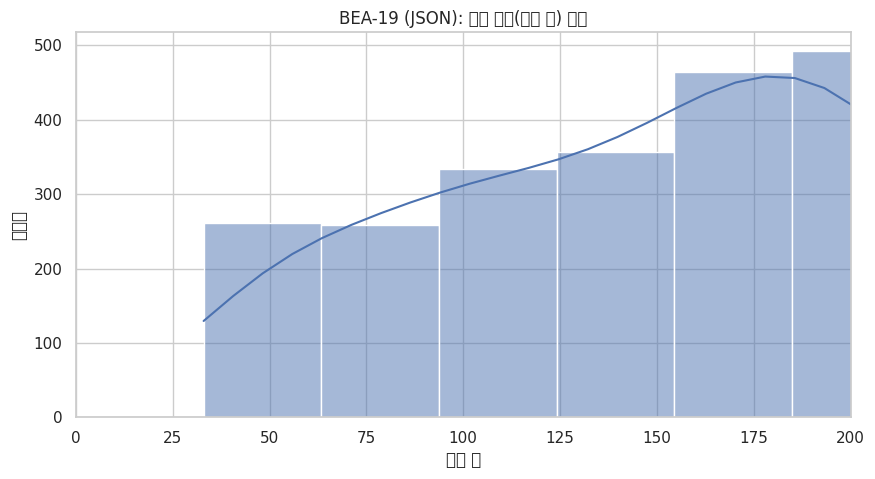

평균 문장 길이: 185.47
최대 문장 길이: 1551
문장 길이 상위 95% 지점: 364.00


In [23]:
df_json["text_word_len"] = df_json["text"].astype(str).str.split().str.len()
display(df_json.head())

# 문장 길이 시각화
plt.figure(figsize=(10, 5))
sns.histplot(df_json["text_word_len"], kde=True, bins=50)
plt.title("BEA-19 (JSON): 문장 길이(단어 수) 분포")
plt.xlabel("단어 수")
plt.ylabel("빈도수")
plt.xlim(0, 200)
plt.show()

# 평균 및 최대 문장 길이 출력
print(f"평균 문장 길이: {df_json['text_word_len'].mean():.2f}")
print(f"최대 문장 길이: {df_json['text_word_len'].max()}")
print(f"문장 길이 상위 95% 지점: {df_json['text_word_len'].quantile(0.95):.2f}")

### `edits` 개수

In [24]:
print(df_json["text"].iloc[0])
df_json["edits"].iloc[0]

My town is a medium size city with eighty thousand inhabitants. It has a high density population because its small territory. Despite of it is an industrial city, there are many shops and department stores.  I recommend visiting the artificial lake in the certer of the city which is surrounded by a park. Pasteries are very common and most of them offer the special dessert from the city. There are a comercial zone along the widest street of the city where you can find all kind of establishments: banks, bars, chemists, cinemas, pet shops, restaurants, fast food restaurants, groceries, travel agencies, supermarkets and others. Most of the shops have sales and offers at least three months of the year: January, June and August. The quality of the products and services are quite good, because there are a huge competition, however I suggest you taking care about some fakes or cheats.


"[[0, [[13, 24, 'medium-sized'], [77, 78, '-'], [104, 104, ' of'], [126, 133, 'Although'], [134, 136, ''], [256, 262, 'center'], [306, 315, None], [375, 379, 'of'], [396, 399, 'is'], [402, 411, 'commercial'], [476, 480, 'kinds'], [484, 498, 'businesses'], [579, 588, 'grocers'], [671, 671, ' in'], [774, 777, 'is'], [804, 807, 'is'], [808, 810, ''], [826, 835, '. However,'], [838, 845, 'recommend'], [850, 856, 'be'], [857, 861, 'careful'], [862, 867, 'of'], [868, 873, '']]]]"

In [25]:
# 각 문장당 edit(수정) 개수 계산
def count_edits_fixed(ed):
    # NaN/None
    if ed is None or (isinstance(ed, float) and math.isnan(ed)):
        return 0

    # 문자열(JSON 또는 파이썬 리터럴) -> 파싱
    if isinstance(ed, str):
        s = ed.strip()
        try:
            ed = json.loads(s)
        except Exception:
            try:
                ed = ast.literal_eval(s)
            except Exception:
                return 0

    # 이미 [[score, [[s,e,repl], ...]]]
    if (isinstance(ed, (list, tuple)) and ed
        and isinstance(ed[0], (list, tuple)) and len(ed[0]) > 1
        and isinstance(ed[0][1], (list, tuple))):
        inner = ed[0][1]
        return sum(1 for x in inner if isinstance(x, (list, tuple)) and len(x) == 3)

    # 이미 [[s,e,repl], ...] 형태
    if (isinstance(ed, (list, tuple)) and ed
        and all(isinstance(x, (list, tuple)) and len(x) == 3 for x in ed)):
        return len(ed)

    return 0

df_json["num_edits"] = df_json["edits"].apply(count_edits_fixed)
df_json.head()

,text,id,cefr,edits,userid,text_word_len,num_edits
0,My town is a medium size city with eighty thou...,1-140178,A2.i,"[[0, [[13, 24, 'medium-sized'], [77, 78, '-'],...",21251,150,23
1,Everyone has his own plans. People want to be ...,1-181175,A2.i,"[[0, [[28, 34, 'Some people'], [56, 61, 'other...",26311,130,21
2,Now days each family has more then 1 car for e...,1-59315,A2.ii,"[[0, [[0, 8, 'Nowadays,'], [30, 34, 'than'], [...",7144,157,30
3,"Furthermore, the biggest group of positive fee...",1-232774,A1.i,"[[0, [[34, 82, None], [184, 191, 'fluently'], ...",33214,77,10
4,MORE THAN KIP FIT!\n\nDo you know mountain bik...,1-352674,A2.ii,"[[0, [[10, 13, 'KEEP'], [31, 31, ' about'], [1...",45225,192,20


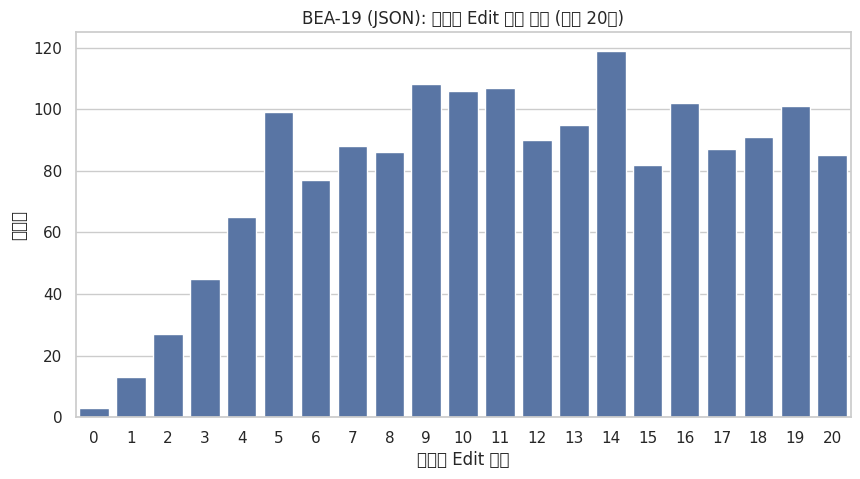

평균 Edit 개수: 22.34
Edit가 하나 이상 있는 문장 비율: 99.90%
Edit가 없는 문장 (No-Op) 비율: 0.10%


In [26]:
# 문장당 Edit 개수 분포 시각화
plt.figure(figsize=(10, 5))
edit_counts_vis = df_json["num_edits"].value_counts().sort_index()
edit_counts_vis = edit_counts_vis[edit_counts_vis.index <= 20]
sns.barplot(x=edit_counts_vis.index, y=edit_counts_vis.values)
plt.title("BEA-19 (JSON): 문장당 Edit 개수 분포 (상위 20개)")
plt.xlabel("문장당 Edit 개수")
plt.ylabel("빈도수")
plt.show()

# 평균 Edit 개수 및 Edit가 있는 문장 비율 출력
print(f"평균 Edit 개수: {df_json['num_edits'].mean():.2f}")
print(f"Edit가 하나 이상 있는 문장 비율: {(df_json['num_edits'] > 0).mean()*100:.2f}%")
print(f"Edit가 없는 문장 (No-Op) 비율: {(df_json['num_edits'] == 0).mean()*100:.2f}%")

[해석]

- 많은 오류를 포함
- 하나의 문장 내에서 많은 오류를 동시에 탐지하고 수정해야 함
    - `Seq2Seq(T5, BART)` 모델 적합성
- 수정없는 데이터 비율이 낮기 때문에 모델이 올바른 문장까지 불필요하게 수정하려는 경향이 보일 수도 있음.

## 2. EDA(SRC/TGT)

In [52]:
df = pd.read_csv("/content/drive/MyDrive/Projects/LikeLion/실전프로젝트02/bea19_train.csv")
df.head()

,noise,clean
0,My town is a medium size city with eighty thou...,My town is a medium - sized city with eighty t...
1,It has a high density population because its s...,It has a high - density population because of ...
2,"Despite of it is an industrial city , there ar...","Although it is an industrial city , there are ..."
3,I recommend visiting the artificial lake in th...,I recommend visiting the artificial lake in th...
4,Pasteries are very common and most of them off...,Pasteries are very common and most of them off...


### 오류 존재 및 빈도 분석

In [53]:
# 'noisy'와 'clean'이 다른 경우 True
df["is_corrected"] = (df["noise"] != df["clean"])

correction_ratio = df["is_corrected"].mean()

print(f"전체 샘플 중 수정된 샘플의 비율: {correction_ratio:.2%}")

전체 샘플 중 수정된 샘플의 비율: 98.66%


### 오류 수정 규모 (편집 거리) 분석

In [54]:
# ---------------------------------
# 2-1. 문자(Character) 레벨 편집 거리
# ---------------------------------
df["char_edit_distance"] = df.apply(
    lambda row: Levenshtein.distance(str(row["noise"]), str(row["clean"])),
    axis=1
)

print("\n[문자 레벨 편집 거리 통계]")
# 오류가 있는 샘플들만 통계 확인
print(df[df["is_corrected"]]["char_edit_distance"].describe())


[문자 레벨 편집 거리 통계]
count    22737.000000
mean         9.810749
std          9.853029
min          1.000000
25%          3.000000
50%          7.000000
75%         13.000000
max        185.000000
Name: char_edit_distance, dtype: float64


In [55]:
# ---------------------------------
# 2-2. 토큰(Word) 레벨 편집 거리
# ---------------------------------

def get_token_edit_distance(row):
    noise_tokens = nltk.word_tokenize(str(row["noise"]))
    clean_tokens = nltk.word_tokenize(str(row["clean"]))
    return nltk.edit_distance(noise_tokens, clean_tokens)

# tqdm을 사용하여 apply 진행 상황 확인
tqdm.pandas(desc="Token Edit Distance 계산 중")
df["token_edit_distance"] = df.progress_apply(get_token_edit_distance, axis=1)

print("\n[토큰 레벨 편집 거리 통계]")
# 오류가 있는 샘플들만 통계 확인
print(df[df["is_corrected"]]["token_edit_distance"].describe())

Token Edit Distance 계산 중:   0%|          | 0/23045 [00:00<?, ?it/s]


[토큰 레벨 편집 거리 통계]
count    22737.000000
mean         3.352949
std          3.328912
min          0.000000
25%          1.000000
50%          2.000000
75%          4.000000
max         73.000000
Name: token_edit_distance, dtype: float64



[편집 거리 분포 시각화 (수정된 샘플 대상)]


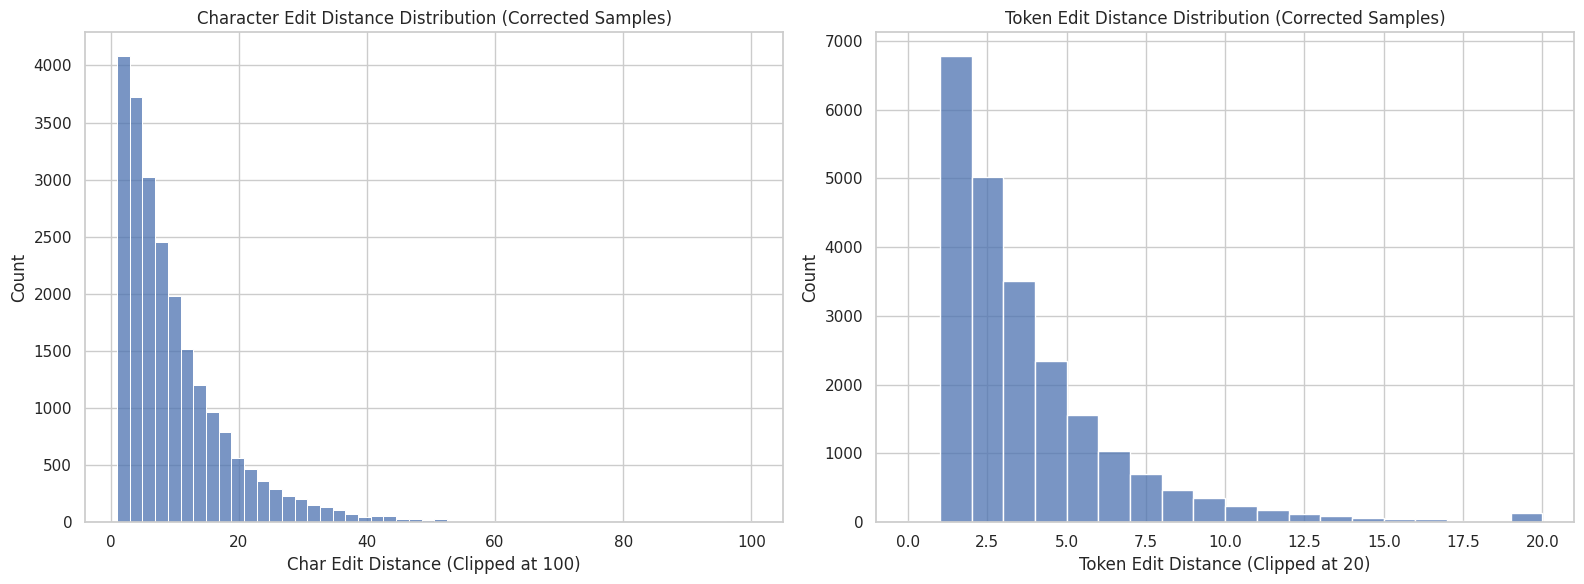

In [56]:
# ---------------------------------
# 2-3. 시각화
# ---------------------------------
print("\n[편집 거리 분포 시각화 (수정된 샘플 대상)]")
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 문자 편집 거리 (100 이상은 하나로 묶음)
sns.histplot(df[df["is_corrected"]]["char_edit_distance"].clip(upper=100), bins=50, ax=axes[0])
axes[0].set_title("Character Edit Distance Distribution (Corrected Samples)")
axes[0].set_xlabel("Char Edit Distance (Clipped at 100)")

# 토큰 편집 거리 (20 이상은 하나로 묶음)
sns.histplot(df[df["is_corrected"]]["token_edit_distance"].clip(upper=20), bins=20, ax=axes[1])
axes[1].set_title("Token Edit Distance Distribution (Corrected Samples)")
axes[1].set_xlabel("Token Edit Distance (Clipped at 20)")

plt.tight_layout()
plt.show()

### 오류 유형 분석 (Token Diff)

In [57]:
# Counter 객체 초기화
deleted_words = Counter()
added_words = Counter()
replaced_pairs = Counter()

# 수정된 샘플들만 순회
corrected_df = df[df["is_corrected"]]

for _, row in tqdm(corrected_df.iterrows(), total=corrected_df.shape[0], desc="Diff 패턴 분석 중"):
    noisy_tokens = nltk.word_tokenize(str(row["noise"]))
    clean_tokens = nltk.word_tokenize(str(row["clean"]))

    # difflib.SequenceMatcher를 사용하여 차이점 분석
    matcher = difflib.SequenceMatcher(None, noisy_tokens, clean_tokens)

    for tag, i1, i2, j1, j2 in matcher.get_opcodes():
        if tag == "delete":
            # 삭제된 토큰들 추가
            deleted_words.update(noisy_tokens[i1:i2])

        elif tag == "insert":
            # 추가된 토큰들 추가
            added_words.update(clean_tokens[j1:j2])

        elif tag == "replace":
            # 대체된 토큰 쌍 추가
            # (noisy_tokens[i1:i2], clean_tokens[j1:j2] 형태)
            # 여기서는 간단히 1:1 매칭만 가정 (실제로는 N:M일 수 있음)
            noisy_segment = " ".join(noisy_tokens[i1:i2])
            clean_segment = " ".join(clean_tokens[j1:j2])
            replaced_pairs.update([(noisy_segment, clean_segment)])

print("\n[가장 많이 삭제된 단어 Top 20]")
print(deleted_words.most_common(20))

print("\n[가장 많이 추가된 단어 Top 20]")
print(added_words.most_common(20))

print("\n[가장 많이 대체된 (Noisy -> Clean) 쌍 Top 20]")
print(replaced_pairs.most_common(20))

Diff 패턴 분석 중:   0%|          | 0/22737 [00:00<?, ?it/s]


[가장 많이 삭제된 단어 Top 20]
[('the', 1525), (',', 555), ('a', 407), ('of', 299), ('to', 254), ('in', 186), ('it', 136), ('for', 120), ('that', 105), ('is', 105), ('have', 85), ("'s", 83), ('and', 70), ('also', 69), ('are', 63), ('with', 61), ('as', 57), ('you', 53), ('will', 52), ('an', 50)]

[가장 많이 추가된 단어 Top 20]
[(',', 6217), ('the', 1388), ('a', 945), ('.', 579), ('to', 392), ('it', 345), ('of', 309), ('is', 253), ('-', 246), ('and', 215), ('in', 185), ('for', 179), ('that', 158), ('an', 155), ("'s", 153), ('have', 142), ('are', 138), ('will', 104), ('you', 93), ('be', 87)]

[가장 많이 대체된 (Noisy -> Clean) 쌍 Top 20]
[((',', '.'), 367), (('in', 'on'), 232), (('the', 'a'), 227), (('i', 'I'), 171), (('in', 'at'), 161), (('on', 'in'), 158), (('to', 'for'), 131), (('is', 'are'), 129), (('a', 'the'), 127), (('are', 'is'), 125), (('will', 'would'), 122), (('is', 'was'), 113), (('can', 'could'), 113), (('for', 'to'), 112), ((',', ';'), 107), (('of', 'in'), 105), ((', it', '. It'), 99), (('would', 'w

### 문장 길이와 오류 상관관계

문장 길이(토큰 수)와 토큰 편집 거리 간의 상관계수: 0.6095
- 문장이 길수록 수정량이 많아지는 경향이 있다.
- 모델이 긴 문맥(long-range dependency)을 잘 처리하는지 확인이 필요.

[문장 길이 vs 토큰 편집 거리 시각화 (샘플링)]


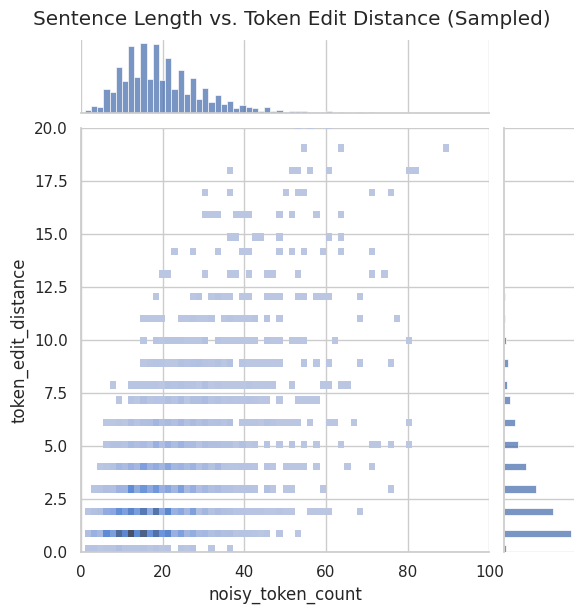

In [58]:
# 'noisy' 문장의 토큰 길이 계산
df["noisy_token_count"] = df["noise"].apply(lambda x: len(nltk.word_tokenize(str(x))))

# 문장 길이와 토큰 편집 거리 간의 상관관계 계산
correlation = df["noisy_token_count"].corr(df["token_edit_distance"])

print(f"문장 길이(토큰 수)와 토큰 편집 거리 간의 상관계수: {correlation:.4f}")

if correlation > 0.3:
    print("- 문장이 길수록 수정량이 많아지는 경향이 있다.")
    print("- 모델이 긴 문맥(long-range dependency)을 잘 처리하는지 확인이 필요.")
elif correlation < 0.1:
    print("- 문장 길이와 오류 발생은 큰 직접적 관계가 없을 수 있다.")


# 시각화 (샘플 수가 많으므로 2D 히스토그램 또는 jointplot(sample)이 유용)
print("\n[문장 길이 vs 토큰 편집 거리 시각화 (샘플링)]")
# 데이터가 너무 많으면 오래 걸리므로 5000개 샘플링
sample_df = df.sample(n=min(5000, len(df)))

sns.jointplot(
    data=sample_df,
    x="noisy_token_count",
    y="token_edit_distance",
    kind="hist", # 'scatter', 'kde', 'hex' 등으로 변경 가능
    xlim=(0, 100), # 적절히 조절
    ylim=(0, 20)   # 적절히 조절
)
plt.suptitle("Sentence Length vs. Token Edit Distance (Sampled)", y=1.02)
plt.show()